In [ ]:
import sys
sys.path.append('/Users/bilgecagaydogdu/Desktop/mobile_phone_indicators/')

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import warnings
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta


In [3]:
from helper_functions.finegrained_helper import read_fine_grained,customer_signals_analysis,calculate_date_values,filter_customers,daily_home_location_series_sort_approach
from helper_functions.antenna_helper import read_antenna_data,dataframe_length_calculator,antenna_variable_histogram,antenna_aggregate_calls
from helper_functions.tower_helper import read_tower_data,find_sites_in_buffer,plot_sites,create_point_buffer
from segregation_indicators.social_indicators import social_connectedness_antenna
from mobility_indicators.simple_migration_flow_indicators import monthy_frequency_based_migration_detection
from mobility_indicators.mobility_indicators import detect_trips, adjust_trips_to_nearest_week
from helper_functions.map_helper import read_map_district

<h1>GEOGRAPHIC DATA</h1>

In [5]:
target_crs = "EPSG:32635"  # Change as per your requirement
district_maps = "/Users/bilgecagaydogdu/Desktop/Geodirectory/turkey_administrativelevels0_1_2/tur_polbnda_adm2.shp"
tower_location="/Volumes/Extreme Pro/Cell_Tower_Locations/cell_city_district.txt"
gdf = gpd.read_file("/Volumes/Extreme Pro/Cell_Tower_Locations/turkcell_voronoi/voronoi.shp", geometry='geometry')
gdf.crs="EPSG:5636"
gdf=gdf.to_crs(target_crs)

df_tower=read_tower_data(tower_location)
gdf_districts = read_map_district(district_maps)
#df_tower["city_district"]=df_tower['city'].astype(str) + '_' + df_tower['district'].astype(str)
gdf_districts=df_tower.drop_duplicates(subset=["city_district_id"]).drop(columns=['site_id','city','district']).merge(gdf_districts, on=['city_district'],how='left')

<h1> ANTENNA

In [1]:
#df_jan=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202301.txt',data_type="CDR")
#df_feb=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202302.txt',data_type="CDR")
#antenna=pd.concat([df_feb,df_jan])
#del(df_feb,df_jan)
#antenna_summed = antenna_aggregate_calls(antenna,df_tower)
#antenna_social = social_connectedness_antenna(antenna, df_tower, level='district',segment=['1-1', '2-2', '1-2', '2-1'])
#antenna_summed=antenna_summed[antenna_summed['week'].isin([1,2,3,4,5,6,7,8])].reset_index(drop=True)
#antenna_social=antenna_social[antenna_social['week'].isin([1,2,3,4,5,6,7,8])].reset_index(drop=True)

In [64]:
df=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202302.txt',data_type="CDR")
df = (df.merge(df_tower[['site_id', 'city_district_id']], left_on='site_id_caller', right_on='site_id',\
                  how='left').rename(columns={'city_district_id': 'city_district_id_caller','city_id': 'city_id_caller'})\
          .drop(columns=['site_id']))
df = df.merge(df_tower[['site_id', 'city_district_id']], left_on='site_id_callee', right_on='site_id', how='left',\
                  suffixes=('', '_callee')).rename(columns={'city_district_id': 'city_district_id_callee',\
                                                            'city_id': 'city_id_caller','site_id': 'site_id_caller'})



In [67]:
agg_df = df.reset_index(drop=True).groupby(['city_district_id_callee','city_district_id_caller']).agg({'call_count': 'sum', 'call_duration': 'sum'}).reset_index()
agg_df['total_calls_callee'] = agg_df.groupby(['city_district_id_callee'])['call_count'].transform('sum')
agg_df['total_calls_caller'] = agg_df.groupby(['city_district_id_caller'])['call_count'].transform('sum')
agg_df['total_calls_caller_callee'] = agg_df.groupby(['city_district_id_caller','city_district_id_callee'])['call_count'].transform('sum')


In [72]:
agg_df_syrian

,city_district_id_callee,city_district_id_caller,call_count,call_duration,total_calls_callee,total_calls_caller,sci,normalized_sci
0,1.0,2.0,27,4527,40543,217639,3.059928e-09,0.002130
1,1.0,3.0,10,859,40543,244236,1.009891e-09,0.000699
2,1.0,5.0,1,51,40543,22467,1.097840e-09,0.000761
3,1.0,6.0,3,752,40543,40281,1.836983e-09,0.001276
4,1.0,7.0,39,5094,40543,202422,4.752160e-09,0.003311
...,...,...,...,...,...,...,...,...
345929,977.0,953.0,2,255,22045,47412,1.913514e-09,0.001330
345930,977.0,955.0,2,136,22045,166015,5.464778e-10,0.000376
345931,977.0,964.0,1,339,22045,19897,2.279829e-09,0.001586
345932,977.0,966.0,1,253,22045,51135,8.870981e-10,0.000614


In [71]:
agg_df_syrian = df[df["segment_caller_callee"]=='2-2'].reset_index(drop=True).groupby(['city_district_id_callee','city_district_id_caller']).agg({'call_count': 'sum', 'call_duration': 'sum'}).reset_index()
agg_df_syrian=agg_df_syrian.merge(agg_df[['city_district_id_callee','city_district_id_caller','total_calls_callee','total_calls_caller']], on=['city_district_id_callee','city_district_id_caller'],how='left')
agg_df_syrian['sci'] = agg_df_syrian['call_count'] / (agg_df_syrian['total_calls_callee']*agg_df_syrian['total_calls_caller'])
agg_df_syrian['normalized_sci'] = (agg_df_syrian['sci'] - agg_df_syrian['sci'].min()) / (agg_df_syrian['sci'].max() - agg_df_syrian['sci'].min())

In [73]:
agg_df_turkish = df[df["segment_caller_callee"]=='1-1'].reset_index(drop=True).groupby(['city_district_id_callee','city_district_id_caller']).agg({'call_count': 'sum', 'call_duration': 'sum'}).reset_index()
agg_df_turkish=agg_df_turkish.merge(agg_df[['city_district_id_callee','city_district_id_caller','total_calls_callee','total_calls_caller']], on=['city_district_id_callee','city_district_id_caller'],how='left')
agg_df_turkish['sci'] = agg_df_turkish['call_count'] / (agg_df_turkish['total_calls_callee']*agg_df_turkish['total_calls_caller'])
agg_df_turkish['normalized_sci'] = (agg_df_turkish['sci'] - agg_df_turkish['sci'].min()) / (agg_df_turkish['sci'].max() - agg_df_turkish['sci'].min())

In [74]:
agg_df_syrian_turkish = df[(df["segment_caller_callee"]=='2-1')|(df["segment_caller_callee"]=='1-2')].reset_index(drop=True).groupby(['city_district_id_callee','city_district_id_caller']).agg({'call_count': 'sum', 'call_duration': 'sum'}).reset_index()
agg_df_syrian_turkish=agg_df_syrian_turkish.merge(agg_df[['city_district_id_callee','city_district_id_caller','total_calls_callee','total_calls_caller']], on=['city_district_id_callee','city_district_id_caller'],how='left')

agg_df_syrian_turkish['sci'] = agg_df_syrian_turkish['call_count'] / (agg_df_syrian_turkish['total_calls_callee']*agg_df_syrian_turkish['total_calls_caller'])
agg_df_syrian_turkish['normalized_sci'] = (agg_df_syrian_turkish['sci'] - agg_df_syrian_turkish['sci'].min()) / (agg_df_syrian_turkish['sci'].max() - agg_df_syrian_turkish['sci'].min())

In [75]:
df2=pd.read_csv("/Volumes/Extreme Pro/gravity-radiation-models.csv", index_col=0)
fdf=df2[df2['destination_city']!=df2['origin_city']][['origin_loc','destination_loc','week','segment','flow_count','destination_district','destination_city','origin_district','origin_city'\
                                                  ]].drop_duplicates(subset=['origin_loc','destination_loc','week','segment']).reset_index(drop=True).sort_values(by=['origin_loc','destination_loc','week','segment'])\
.merge(gdf_districts[['city_district_id','geometry']],left_on='origin_loc',right_on='city_district_id',how='left').rename(columns={'geometry':'origin_geometry'}).drop(columns=['city_district_id'])\
.merge(gdf_districts[['city_district_id','geometry']],left_on='destination_loc',right_on='city_district_id',how='left').rename(columns={'geometry':'destination_geometry'}).drop(columns=['city_district_id'])


In [76]:
fdf=fdf[['origin_loc','destination_loc','segment','destination_district','destination_city','origin_district','origin_city','week','flow_count']]

fdf=fdf[(fdf['week']==6)|(fdf['week']==7)].groupby(['origin_loc','destination_loc','segment','destination_district','destination_city','origin_district','origin_city']).count().reset_index().drop(columns=['week'])

In [77]:
fdf

,origin_loc,destination_loc,segment,destination_district,destination_city,origin_district,origin_city,flow_count
0,1,383,2,NIZIP,GAZIANTEP,ALADAG,ADANA,1
1,1,778,1,DUZICI,OSMANIYE,ALADAG,ADANA,1
2,2,17,1,BESNI,ADIYAMAN,CEYHAN,ADANA,1
3,2,25,2,AFYONKARAHISAR,AFYONKARAHISAR,CEYHAN,ADANA,1
4,2,52,2,AKSARAY,AKSARAY,CEYHAN,ADANA,1
...,...,...,...,...,...,...,...,...
23827,977,451,1,BAGCILAR,ISTANBUL,ZONGULDAK,ZONGULDAK,1
23828,977,452,1,BAHCELIEVLER,ISTANBUL,ZONGULDAK,ZONGULDAK,1
23829,977,483,1,UMRANIYE,ISTANBUL,ZONGULDAK,ZONGULDAK,1
23830,977,524,1,ONIKISUBAT,KAHRAMANMARAS,ZONGULDAK,ZONGULDAK,1


In [78]:
fdf=fdf.merge(agg_df_turkish[['city_district_id_caller','city_district_id_callee','normalized_sci']], left_on=['origin_loc','destination_loc'], right_on=['city_district_id_caller','city_district_id_callee'], how='left')\
          .rename(columns={'normalized_sci':'normalized_sci_tr'}).drop(columns=['city_district_id_caller','city_district_id_callee'])
fdf=fdf.merge(agg_df_syrian[['city_district_id_caller','city_district_id_callee','normalized_sci']], left_on=['origin_loc','destination_loc'], right_on=['city_district_id_caller','city_district_id_callee'], how='left')\
          .rename(columns={'normalized_sci':'normalized_sci_syria'}).drop(columns=['city_district_id_caller','city_district_id_callee'])
fdf=fdf.merge(agg_df_syrian_turkish[['city_district_id_caller','city_district_id_callee','normalized_sci']], left_on=['origin_loc','destination_loc'], right_on=['city_district_id_caller','city_district_id_callee'], how='left')\
          .rename(columns={'normalized_sci':'normalized_sci_tr_syria'}).drop(columns=['city_district_id_caller','city_district_id_callee'])

fdf       

,origin_loc,destination_loc,segment,destination_district,destination_city,origin_district,origin_city,flow_count,normalized_sci_tr,normalized_sci_syria,normalized_sci_tr_syria
0,1,383,2,NIZIP,GAZIANTEP,ALADAG,ADANA,1,0.000727,NaN,NaN
1,1,778,1,DUZICI,OSMANIYE,ALADAG,ADANA,1,NaN,NaN,NaN
2,2,17,1,BESNI,ADIYAMAN,CEYHAN,ADANA,1,0.000141,0.002752,0.000323
3,2,25,2,AFYONKARAHISAR,AFYONKARAHISAR,CEYHAN,ADANA,1,0.000407,0.002818,0.000203
4,2,52,2,AKSARAY,AKSARAY,CEYHAN,ADANA,1,0.000349,0.002943,0.000250
...,...,...,...,...,...,...,...,...,...,...,...
23827,977,451,1,BAGCILAR,ISTANBUL,ZONGULDAK,ZONGULDAK,1,0.000225,0.000246,NaN
23828,977,452,1,BAHCELIEVLER,ISTANBUL,ZONGULDAK,ZONGULDAK,1,0.000270,0.000519,NaN
23829,977,483,1,UMRANIYE,ISTANBUL,ZONGULDAK,ZONGULDAK,1,0.000578,0.000088,NaN
23830,977,524,1,ONIKISUBAT,KAHRAMANMARAS,ZONGULDAK,ZONGULDAK,1,0.000233,0.000060,NaN


In [84]:
A=fdf[fdf['segment']==2].reset_index()
B=fdf[fdf['segment']==1].reset_index()

print(A['normalized_sci_syria'].corr(A['flow_count']))
print(A['normalized_sci_tr_syria'].corr(A['flow_count']))
print(B['normalized_sci_tr'].corr(B['flow_count']))
print(B['normalized_sci_tr_syria'].corr(B['flow_count']))


0.09816539058536392
0.03989812248102368
0.04928872541676714
-0.004160628313430152


In [86]:
import scipy.stats
corr_info_A_syria = scipy.stats.pearsonr(A[A['normalized_sci_syria'].isnull()==False]['normalized_sci_syria'], A[A['normalized_sci_syria'].isnull()==False]['flow_count'])
corr_info_A_tr_syria = scipy.stats.pearsonr(A[A['normalized_sci_tr_syria'].isnull()==False]['normalized_sci_tr_syria'], A[A['normalized_sci_tr_syria'].isnull()==False]['flow_count'])
corr_info_B_tr = scipy.stats.pearsonr(B[B['normalized_sci_tr'].isnull()==False]['normalized_sci_tr'], B[B['normalized_sci_tr'].isnull()==False]['flow_count'])
corr_info_B_tr_syria = scipy.stats.pearsonr(B[B['normalized_sci_tr_syria'].isnull()==False]['normalized_sci_tr_syria'], B[B['normalized_sci_tr_syria'].isnull()==False]['flow_count'])
print(corr_info_A_syria,corr_info_A_tr_syria,corr_info_B_tr,corr_info_B_tr_syria)

PearsonRResult(statistic=0.09816539058536736, pvalue=1.2631852519288984e-19) PearsonRResult(statistic=0.03989812248102242, pvalue=0.0009049944821003434) PearsonRResult(statistic=0.0492887254167656, pvalue=8.312112261634454e-08) PearsonRResult(statistic=-0.004160628313430346, pvalue=0.6941166571063035)


In [16]:
antenna_social = social_connectedness_antenna(antenna, tower_location, level='district',segment=['1-1', '2-2', '1-2', '2-1'])


        segment_caller_callee       date  hour  site_id_callee  \
1000992                   1-1 2022-10-01  13.0         16177.0   
2826065                   1-1 2022-10-01  11.0          5753.0   

         site_id_caller  call_duration  call_count                time  week  \
1000992         11206.0           19.0         1.0 2022-10-01 13:00:00    39   
2826065          5528.0           44.0         1.0 2022-10-01 11:00:00    39   

         segment_caller  segment_callee  city_district_id_caller  \
1000992               1               1                      1.0   
2826065               1               1                      1.0   

         site_id_caller  city_district_id_callee  
1000992         16177.0                      8.0  
2826065          5753.0                      8.0  


KeyError: 2.0

In [70]:
antenna_social = social_connectedness_antenna(antenna, df_tower, level='district')
antenna_social=antenna_social[antenna_social['week'].isin([1,2,3,4,5,6,7,8])].reset_index(drop=True)
antenna_social=antenna_social[['week','segment_caller_callee','city_district_id_caller','city_district_id_callee','call_count','call_duration','total_calls','normalized_sci','combined_sci']]
antenna_social['caller_callee_pair'] =antenna_social.apply(lambda x: tuple(sorted([x['city_district_id_caller'], x['city_district_id_callee']])), axis=1)


In [109]:
antenna_social['normalized_sci']=antenna_social['normalized_sci'].fillna(0)
antenna_social['combined_sci']=antenna_social['combined_sci'].fillna(0)
grouped = antenna_social.groupby(['week', 'segment_caller_callee', 'caller_callee_pair'])[['normalized_sci', 'combined_sci']].mean().reset_index()

# Rename the columns to indicate these are averaged values
grouped = grouped.rename(columns={'normalized_sci': 'avg_normalized_sci', 'combined_sci': 'avg_combined_sci'})

# Split the caller_callee_pair back into two columns to facilitate merging
grouped[['city_district_id_caller', 'city_district_id_callee']] = pd.DataFrame(grouped['caller_callee_pair'].tolist(), index=grouped.index)
grouped[['segment_caller', 'segment_callee']] = grouped['segment_caller_callee'].str.split('-', expand=True)


In [104]:
#file=f'/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_20230{i}.txt'
#for i in range(1,10):
#    print(i)
#    file_i=file.format(i)
#    df = read_antenna_data(file_i,data_type="CDR")
    # Line plot for total calls every hour of each day
    #i = i[i['DAY']==i.iloc[1]['DAY']]
#    total_calls = pd.pivot_table(df,index=['time'],values=['call_duration'],aggfunc='sum')
    #total_calls = df[df['CALLEE_MATCHER'].isin(sites)].groupby('DATETIME').size()
#    plt.figure(figsize=(12, 6))
#    total_calls.plot(kind='line')
#    plt.title('Total Calls Every Hour')
#    plt.xlabel('Datetime')
#    plt.ylabel('Number of Calls')
#    plt.show()
#    dataframe_length_calculator(df)
#    antenna_variable_histogram(df)
#    del(df)
#['7', '7_2', '7_3', '7_4', '7_5', '7_6']
#for i in range(2,8):
#    file=f"/Volumes/Extreme Pro/Data-CDR/Incoming/Fine_grained/INC_FGM{i}.txt".format(i)
#    print(read_fine_grained(file,datatype='CDR').groupby('segment_caller').count())

<h1>FINE GRAINED

In [7]:
file_path = "/Volumes/Extreme Pro/Data-CDR/Incoming/Fine_grained/INC_FGM{}.txt"
output_path='/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/monthly_incoming_fgrained.csv'
file_path2 = "/Volumes/Extreme Pro/Data-CDR/Outgoing/Fine_grained/FGM_{}.txt"
output_path2='/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/monthly_outgoing_fgrained.csv'
#accumulated_df_incoming = daily_home_location_series_sort_approach(file_path, "INCOMING",tower_location,cust_list=None,spatial_level='district')
accumulated_df_outgoing = daily_home_location_series_sort_approach(file_path2, "OUTGOING",tower_location,cust_list=None,spatial_level='district')
#df=pd.concat([accumulated_df_incoming,accumulated_df_outgoing]) 
#df['segment'] = np.where(df['segment_callee'].isnull(), df['segment_caller'], df['segment_callee'])
#df=df[['date','user_id','location', 'segment']]
#df.to_csv('/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/mig_detector.csv')

7
7_2
7_3
7_4
7_5
7_6


<h1> A. MIGRATION FLOWS

Turkey-Syria earthquake 2


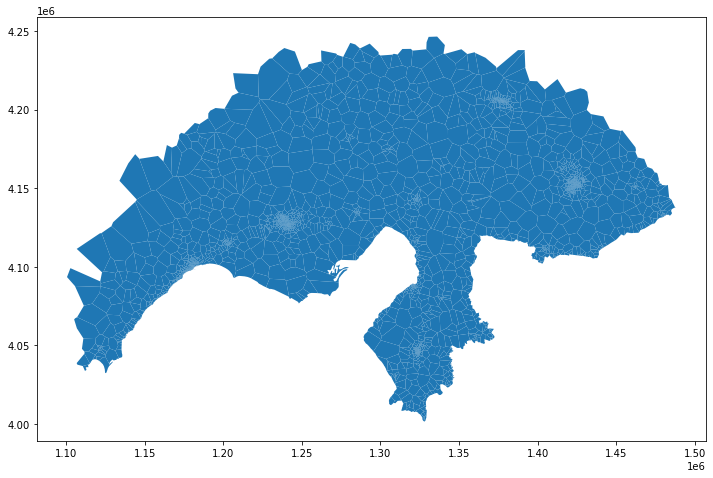

In [7]:
points = {
    #'Istiklal street bombing': (41.036322, 28.984614, 500, "EPSG:4326"),#istiklal
    #'Syrian border conflict bombing': (36.836082, 37.994714, 2000, "EPSG:4326"),#sınırdaki patlama
    #'Stadium football match': (41.122711, 28.807796, 500, "EPSG:4326"),#stadyum
    #'Tokat earthquake': (40.846944, 30.9669445, 20000, "EPSG:4326"),
    #'Turkey-Syria earthquake 1':(37.225000, 37.021000,90000, "EPSG:4326"),
    'Turkey-Syria earthquake 2':(36.114128, 36.030515,200000, "EPSG:4326")
}#36.435705, 36.650604 

# Calculate buffers and find sites
for point_name, (lat, lon, radius, input_crs) in points.items():
    buffer_gdf = create_point_buffer(lat, lon, radius, input_crs, target_crs)
    sites = find_sites_in_buffer(gdf, buffer_gdf)
    gdf[gdf['matcher'].isin(sites)==True].plot(figsize=(12,18))
    print(point_name)


In [35]:
#df=pd.read_csv("/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/mig_detector.csv", index_col=0)
tessellation=gpd.GeoDataFrame(gdf_districts[['city_district_id','geometry']].rename(columns={'city_district_id':'tile_ID'}),geometry='geometry')

flow=FlowDataFrame(fdf[(fdf['week']==6)&(fdf['segment']==1)][['origin_loc','flow_count','destination_loc']].reset_index(drop=True),origin='origin_loc',destination='destination_loc',flow='flow_count',tessellation=tessellation)
tessellation['tile_ID']=tessellation['tile_ID'].astype(int)
flow['origin']=flow['origin'].astype(int)
flow['destination']=flow['destination'].astype(int)
flow.plot_flows(flow_color='red')


<h2> A.1 O-D MATRICES

In [ ]:
#df=accumulated_df_outgoing.copy()
#df=df.rename(columns={'segment_caller':'segment'})
#df=df[['date','user_id','location', 'segment']]
df['week'] = df['date'].dt.isocalendar().week

In [2]:
#earthquake_city_district_list=df_tower[df_tower["site_id"].isin(sites)==True]['city_district_id'].unique().tolist()
#earthquake_user_list=df[(df['date'].dt.month==1)&(df['location'].isin(earthquake_city_district_list)==True)&(df["location"].isnull()==False)]['user_id'].tolist()
#df_2=df[df['user_id'].isin(earthquake_user_list)==True].reset_index(drop=True)

# Run the function

#trips_df = detect_trips(df[['user_id','date','location']])
#trips_df=trips_df.merge(df[['user_id','segment']].drop_duplicates(subset=['user_id']),on='user_id',how='left')

# Convert date columns to datetime
#trips_df['trip_start_date'] = pd.to_datetime(trips_df['trip_start_date'])
#trips_df['trip_end_date'] = pd.to_datetime(trips_df['trip_end_date'])

# Ensure the trips where origin and destination are different
#trips_df = trips_df[trips_df['origin_loc'] != trips_df['destination_loc']]

# Apply the function to adjust trips to the nearest week
#adjusted_trips_df = trips_df.apply(adjust_trips_to_nearest_week, axis=1)

# Add a week column based on the adjusted trip start date
#adjusted_trips_df['week'] = adjusted_trips_df['trip_start_date'].dt.strftime('%Y-%U')

# Aggregate trips into weekly O-D matrices per segment
#c = adjusted_trips_df.groupby(['week', 'segment', 'origin_loc', 'destination_loc']).size().reset_index(name='flow_count')

#weekly_od_matrix=weekly_od_matrix.merge(gdf_districts[['city_district_id','district','city']],right_on='city_district_id',left_on='destination_loc')\
#.rename(columns={'district':'destination_district','city':'destination_city'}).drop(columns=['city_district_id']).merge(gdf_districts[['city_district_id','district','city']]\
                                                                                  #,right_on='city_district_id',left_on='origin_loc').rename(columns={'district':'origin_district','city':'origin_city'})

In [ ]:
#weekly_od_matrix.rename(columns={'week': 'date'}, inplace=True)
#weekly_od_matrix['week'] = weekly_od_matrix['date'].apply(lambda x: int(x.split('-')[1]))
#weekly_od_matrix = weekly_od_matrix[weekly_od_matrix['week'].isin(range(1, 9))]
#weekly_od_matrix.drop(columns=['date'], inplace=True)

In [3]:
# Convert segments to the same type if necessary
#weekly_od_matrix['segment'] = weekly_od_matrix['segment'].astype(int)
#grouped['segment_caller'] = grouped['segment_caller'].astype(int)

# Merge the dataframes
#merged_df = pd.merge(weekly_od_matrix, grouped, 
#                     left_on=['week',  'origin_loc', 'destination_loc'], 
#                     right_on=['week', 'city_district_id_caller', 'city_district_id_callee'],
#                     how='left')

# Select and rename columns as needed
#merged_df = merged_df[['week', 'segment', 'origin_loc', 'destination_loc', 'flow_count', 
#                       'destination_district', 'destination_city', 'city_district_id', 'origin_district', 
#                       'origin_city', 'avg_normalized_sci', 'avg_combined_sci','segment_caller_callee']]



In [145]:
merged_df = pd.merge(merged_df, antenna_summed,
                     left_on=['week', 'origin_loc'],
                     right_on=['week', 'city_district_id'],
                     how='left')

# Rename columns after the first merge and drop 'city_district_id'
merged_df.rename(columns={
    'sum_site_call_count': 'origin_sum_site_call_count',
    'sum_site_call_duration': 'origin_sum_site_call_duration'
}, inplace=True)

# Merge on destination_loc
merged_df = pd.merge(merged_df, antenna_summed,
                     left_on=['week', 'destination_loc'],
                     right_on=['week', 'city_district_id'],
                     how='left')

# Rename columns after the second merge and drop 'city_district_id'
merged_df.rename(columns={
    'sum_site_call_count': 'destination_sum_site_call_count',
    'sum_site_call_duration': 'destination_sum_site_call_duration'
}, inplace=True)
data, origin='origin', destination='destination', flow='flow', datetime='datetime',.drop(columns=['city_district_id_x','city_district_id_y'], inplace=True)


SyntaxError: invalid syntax (<ipython-input-145-0c5ba8056a83>, line 23)

<h1> RADIATION MODEL

In [148]:
tessellation = gdf_districts.rename(columns={'city_district_id': 'tile_ID'})
tessellation = gpd.GeoDataFrame(tessellation,geometry='geometry')
fdf = FlowDataFrame(merged_df[merged_df['week']==1].reset_index(drop=True), origin='origin_loc', destination='destination_loc', flow='flow_count',\
                                        tessellation=tessellation,\
                                        tile_id='tile_ID')

In [155]:
tessellation=tessellation.merge(merged_df[['origin_sum_site_call_count','origin_sum_site_call_duration','city_district_id']].drop_duplicates(subset=['city_district_id']),left_on='tile_ID',right_on='city_district_id',how='left')

In [163]:
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0).reset_index()
tot_outflows['origin']=tot_outflows['origin'].astype(int)
tessellation = tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': constants.TOT_OUTFLOW})
np.random.seed(0)
radiation = Radiation()
rad_flows = radiation.generate(tessellation, tile_id_column='tile_ID',  tot_outflows_column='tot_outflow', relevance_column='origin_sum_site_call_count', out_format='flows_sample')


100%|██████████| 833/833 [00:00<00:00, 1014.13it/s]


In [184]:
l=weekly_od_matrix[weekly_od_matrix['week']==1].groupby(['origin_loc','destination_loc']).count().reset_index()[['flow_count','origin_loc','destination_loc']]
l=l.astype(int)
rad_flows=rad_flows.astype(int)
rad_flows=rad_flows.merge(l, left_on=['origin','destination'],right_on=['origin_loc','destination_loc'])

In [185]:
rad_flows['flow_count'].corr(rad_flows['flow'])

0.23099086335444677

<h1> GRAVITY MODEL

In [204]:
from skmob.models import Gravity

gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)
np.random.seed(0)
synth_fdf = gravity_singly.generate(tessellation,
                                   tile_id_column='tile_ID',
                                   tot_outflows_column='tot_outflow',
                                   relevance_column= 'origin_sum_site_call_count',
                                   out_format='flows')
synth_fdf

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


100%|██████████| 833/833 [00:00<00:00, 3181.55it/s]
/Users/bilgecagaydogdu/anaconda3/envs/geo_env/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


,origin,destination,flow
0,453,571,0.035866
1,453,725,0.002703
2,453,92,0.009674
3,453,616,0.102136
4,453,108,0.004450
...,...,...,...
693051,589,269,0.000010
693052,589,842,0.000121
693053,589,22,0.000015
693054,589,58,0.000822


<h2> A.2.1 MIGRATED VS. NON MIGRATED ANALYSIS

In [13]:
#aggregated_df = monthy_frequency_based_migration_detection(df).reset_index(drop=True)
#aggregated_df=aggregated_df.merge(df.drop_duplicates(subset=['user_id'])[['user_id','segment']], on='user_id')
#earthquake_city_district_list=df_tower[df_tower["site_id"].isin(sites)==True]['city_district_id'].unique().tolist()
#earthquake_users_january=aggregated_df[(aggregated_df['month']==1)&(aggregated_df['city_district_id'].isin(earthquake_city_district_list)==True)&(aggregated_df["city_district_id"].isnull()==False)]
#earthquake_users=earthquake_users_january["user_id"].tolist()
#earthquake_users_march=aggregated_df[(aggregated_df['month']==3)&(aggregated_df['user_id'].isin(earthquake_users)==True)]
#migrated_df = aggregated_df[aggregated_df['user_id'].isin(earthquake_users)].groupby('user_id').filter(lambda x: x[x['month'] == 1]['city_district_id'].values[0] != x[x['month'] == 3]['city_district_id'].values[0] if (1 in x['month'].values and 3 in x['month'].values) else False).reset_index(drop=True)
#earthquake_users_january['dummy_migrated'] = np.where(earthquake_users_january['user_id'].isin(migrated_df['user_id']), 1, 0)
#cust_list=earthquake_users_january['user_id'].unique().tolist()
#df_incoming_earthquake_user_sites = daily_home_location_series_sort_approach(file_path, "INCOMING",tower_location,cust_list=cust_list,spatial_level='site')
#df_outgoing_earthquake_user_sites = daily_home_location_series_sort_approach(file_path2, "OUTGOING",tower_location,cust_list=cust_list,spatial_level='site')
#df_outgoing_earthquake_user_sites=df_outgoing_earthquake_user_sites.merge(earthquake_users_january[['dummy_migrated','user_id']],on='user_id')
#df_outgoing_earthquake_user_sites=df_outgoing_earthquake_user_sites.merge(gdf,right_on='matcher',left_on='location')[['date','user_id','location','geometry','segment_caller','count','dummy_migrated']]
#df_outgoing_earthquake_user_sites=gpd.GeoDataFrame(df_outgoing_earthquake_user_sites,geometry='geometry')
#df_outgoing_earthquake_user_sites['centroid'] = df_outgoing_earthquake_user_sites['geometry'].centroid
#df_outgoing_earthquake_user_sites['latitude'] = df_outgoing_earthquake_user_sites['centroid'].y
#df_outgoing_earthquake_user_sites['longitude'] = df_outgoing_earthquake_user_sites['centroid'].x

<h2> A.2.2 DISTRIBUTION IN MARCH

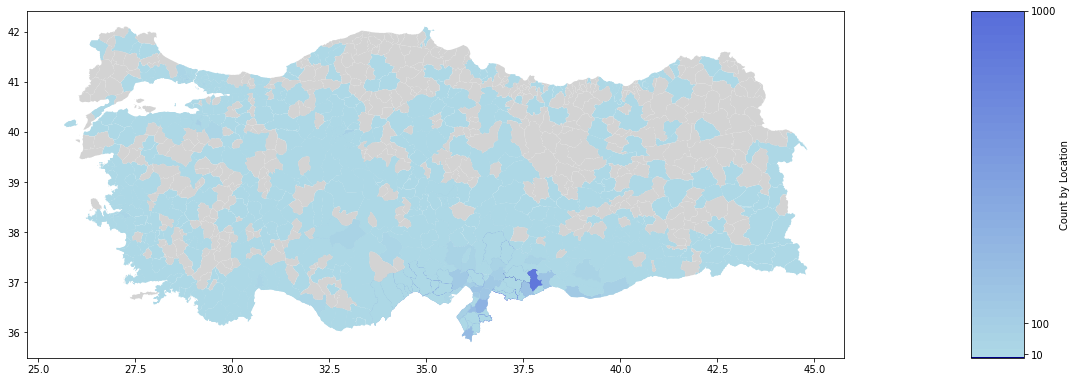

In [16]:
## aggregated march
agg_march = earthquake_users_march.groupby(['city_district_id','segment']).size().reset_index(name='count')
agg_march=agg_march.merge(gdf_districts, on="city_district_id", how='outer')

gdf_agg_march = gpd.GeoDataFrame(agg_march, geometry='geometry')
# Define your custom color map with four shades of blue
cmap = mcolors.LinearSegmentedColormap.from_list("", ["lightblue", "mediumblue", "darkblue", "navy"])
fig, ax = plt.subplots(1, 1, figsize=(20, 10))  # Adjust the figsize to control the size of the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
3
norm = mcolors.BoundaryNorm(boundaries=[0, 10, 100, 1000, gdf_agg_march['count'].max()], ncolors=4)

gdf_agg_march.plot(
    column='count',
    cmap=cmap,
    legend=True,
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    },
    legend_kwds={
        'label': "Count by Location",
        'orientation': "vertical",
    }
)

if ax.get_legend() is None:
    sm = plt.cm.ScalarMappable(cmap=cmap)#,norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Count by Location')
    cbar.set_ticks([10, 100, 1000])
    cbar.set_ticklabels(['10', '100', '1000'])

# Display the plot
plt.show()


<h2> A.2.3 CHECK THE MOBILITY INDICATORS UNTIL THE EARTHQUAKE

In [21]:
df_outgoing_earthquake_user_sites['date'] = pd.to_datetime(df_outgoing_earthquake_user_sites['date'])
filtered_df = df_outgoing_earthquake_user_sites[df_outgoing_earthquake_user_sites['date'] < pd.Timestamp('2023-02-06')]
filtered_df['date'] = filtered_df['date'].dt.strftime('%Y%m%d')
tdf = skmob.TrajDataFrame(filtered_df, latitude='latitude', longitude='longitude', datetime = 'date', user_id='user_id')
rg_df_all = radius_of_gyration(tdf)
#krg_df_all = k_radius_of_gyration(tdf)
re_df_all = random_entropy(tdf) 
ure_df_all = uncorrelated_entropy(tdf)
md_df_all = maximum_distance(tdf)
dsl_df_all = distance_straight_line(tdf)
wt_df_all = waiting_times(tdf)
nol_df_all = number_of_locations(tdf)
hl_df_all = home_location(tdf)
mdfh_df_all = max_distance_from_home(tdf)
nov_df_all = number_of_visits(tdf)
L_all = [re_df_all, ure_df_all, rg_df_all, md_df_all, dsl_df_all, wt_df_all, nol_df_all, hl_df_all, mdfh_df_all, nov_df_all]
for i in L_all:
    rg_df_all = rg_df_all.merge(i, on = 'uid', how = 'left')
rg_df_all=rg_df_all.rename({'uid':'user_id'},axis=1)
rg_df_all = rg_df_all.drop_duplicates(subset='user_id')
df_outgoing_earthquake_user_sites=df_outgoing_earthquake_user_sites.merge(rg_df_all,on='user_id')
df_outgoing_earthquake_user_sites['home_location_centroid'] = df_outgoing_earthquake_user_sites.apply(lambda row: Point(row['lng'], row['lat']), axis=1)

/Users/bilgecagaydogdu/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 57687/57687 [00:03<00:00, 18735.98it/s]


In [28]:
gpd.GeoDataFrame(df_outgoing_earthquake_user_sites,geometry="home_location_centroid")[['user_id','dummy_migrated','segment_caller','home_location_centroid']].drop_duplicates(subset=['user_id']).to_file('/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/homelocations.shp')

<ipython-input-28-3d7c45d03294>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd.GeoDataFrame(df_outgoing_earthquake_user_sites,geometry="home_location_centroid")[['user_id','dummy_migrated','segment_caller','home_location_centroid']].drop_duplicates(subset=['user_id']).to_file('/Users/bilgecagaydogdu/Desktop/EARTHQUAKE/Data/mobile_data/homelocations.shp')


In [33]:
import networkx as nx
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in x.iterrows():
    node_caller = row['city_caller']
    node_callee = row['city_callee']
    if not G.has_node(node_caller):
        G.add_node(node_caller)
        
    if not G.has_node(node_callee):
        G.add_node(node_callee)
    
    G.add_edge(node_caller, node_callee, social_connectedness_index=row['social_connectedness_index'])

# ... Add other edges

# Define the gravity model function
def gravity_model(G, alpha=2):
    flows = {}
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                Pi = G.nodes[i]['social_connectedness_index']
                Pj = G.nodes[j]['social_connectedness_index']
                Dij = G[i][j]['distance']
                flow = (Pi * Pj) / (Dij ** alpha)
                flows[(i, j)] = flow
    return flows

# Calculate flows
flows = gravity_model(G)

# Normalize flows
max_flow = max(flows.values())
normalized_flows = {k: v / max_flow for k, v in flows.items()}


KeyError: 'population'

In [34]:
G